# Titanic - Machine Learning from Disaster

The target is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. The dataset was taken out from Kaggle: "Titanic - Machine Learning from Disaster".

### About the data

I have access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled train.csv and the other is titled test.csv.

Train.csv contains the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not.

The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. 

Using the patterns in the train.csv data, I have to predict whether the other 418 passengers on board (found in test.csv) survived.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Datasets
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
submission=pd.read_csv("gender_submission.csv")
print("Training shape:",df_train.shape," | Test shape:",df_test.shape)


Training shape: (891, 12)  | Test shape: (418, 11)


In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Exploratory Data Analysis
Before building a model, I will analyze and explore our dataset in order to identify patters, missing values and other relevant stuff.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let´s find about duplicated and null info:

In [6]:
print(df_train.duplicated().sum())

0


In [7]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

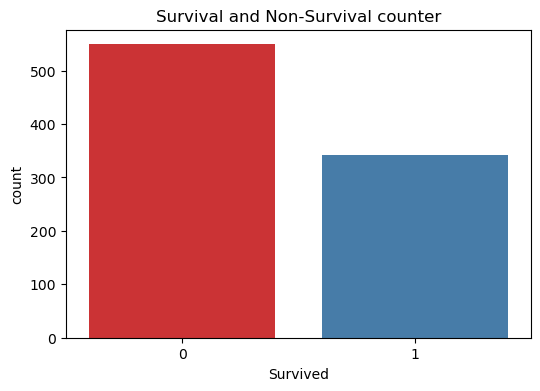

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x= "Survived", hue = "Survived", data = df_train, palette = "Set1", legend = None)
plt.title("Survival and Non-Survival counter")
plt.show()

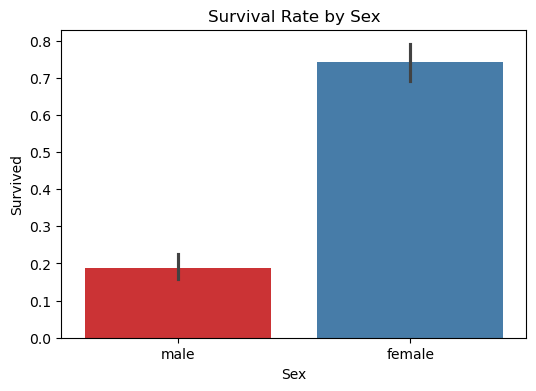

In [9]:
plt.figure(figsize=(6,4))
sns.barplot(x = "Sex", y = "Survived", hue = "Sex", data = df_train, palette = "Set1", legend = None)
plt.title("Survival Rate by Sex")
plt.show()

In [10]:
df_train["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

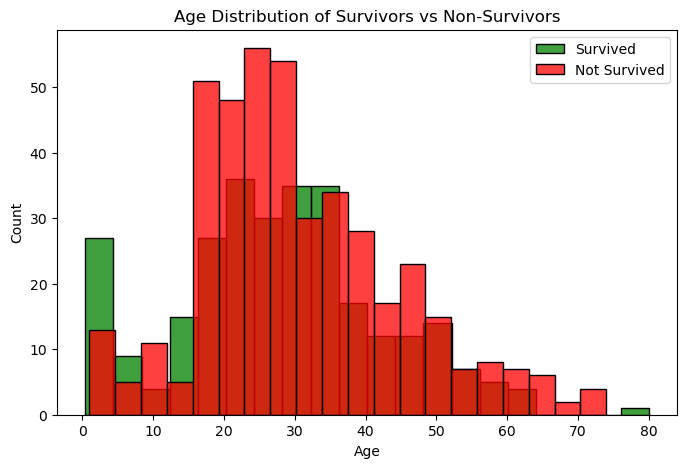

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df_train[df_train["Survived"]==1]["Age"], bins=20, color="green", label="Survived")
sns.histplot(df_train[df_train["Survived"]==0]["Age"], bins=20, color="red", label="Not Survived")
plt.legend()
plt.title("Age Distribution of Survivors vs Non-Survivors")
plt.show()

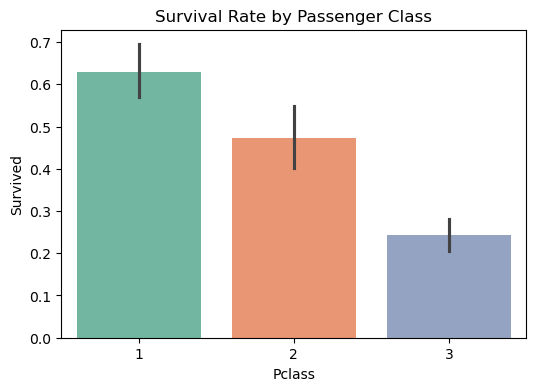

In [12]:
plt.figure(figsize=(6,4))
sns.barplot(x = "Pclass", y = "Survived", data = df_train, hue = "Pclass", palette = "Set2", legend = None)
plt.title("Survival Rate by Passenger Class")
plt.show()

I will drop irrelevant columns:

In [13]:
df_train = df_train.drop(columns=["PassengerId","Cabin","Fare","Ticket","Name"])
df_test = df_test.drop(columns=["PassengerId","Cabin","Fare","Ticket","Name"])
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


I am about to separate df_train in two datasets. X will have all info related to passengers except if the survived or not, because that info will be in Y.

In [14]:
X_train = df_train.drop(columns = ["Survived"])
y_train = df_train.Survived

Before modelling, it is important to move from categorical values to numerical.

In [15]:
X_train.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Embarked     object
dtype: object

In [16]:
sexencoder = OrdinalEncoder()
embarkedencoder = OrdinalEncoder()

X_train['Sex'] = sexencoder.fit_transform(X_train[['Sex']])
X_train['Embarked'] = embarkedencoder.fit_transform(X_train[['Embarked']])

df_test['Sex'] = sexencoder.transform(df_test[['Sex']])
df_test['Embarked'] = embarkedencoder.transform(df_test[['Embarked']])

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,1.0,22.0,1,0,2.0
1,1,0.0,38.0,1,0,0.0
2,3,0.0,26.0,0,0,2.0
3,1,0.0,35.0,1,0,2.0
4,3,1.0,35.0,0,0,2.0


In [17]:
X_train.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Embarked      2
dtype: int64

In [18]:
df_test.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Embarked     0
dtype: int64

In [19]:

X_train['Age'].fillna(X_train['Age'].median(), inplace=True)
X_train['Embarked'].fillna(X_train['Embarked'].median(), inplace=True)

df_test['Age'].fillna(df_test['Age'].median(), inplace=True)

### Model Building

In [20]:
from sklearn import preprocessing

y_train = y_train.values
X_train = X_train.values

X_test = df_test.values

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................

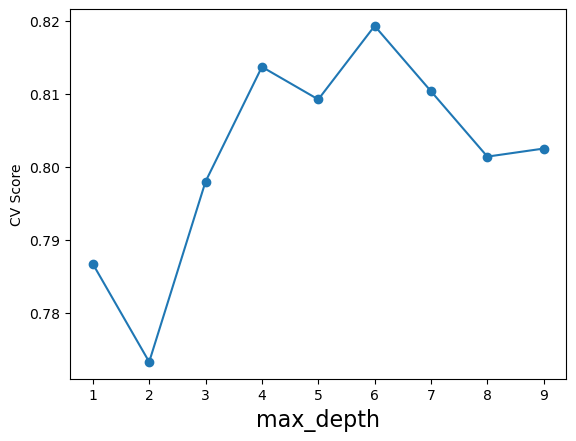

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

maxDepth = range(1,10)
param_grid = {'max_depth': maxDepth }
# ... código aquí
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, verbose=2, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('CV Score')

plt.show()

In [22]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeClassifier(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))

Train:  0.8518518518518519


Teniendo en cuenta el alto valor de max_depth y el score de train, parece que estamos ante un modelo con overfitting.

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=3; total time=   0.3s
[CV] END .......................................

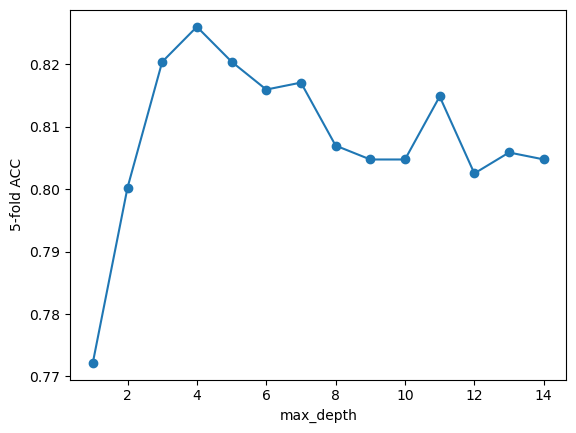

In [23]:
from sklearn.ensemble import RandomForestClassifier

maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

# ... código aquí
grid = GridSearchCV(RandomForestClassifier(), param_grid=tuned_parameters, verbose=2, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('5-fold ACC')

plt.show()

In [24]:
maxDepthOptimo = grid.best_params_['max_depth']
randomForest = RandomForestClassifier(max_depth=3).fit(X_train,y_train)

print("Train: ",randomForest.score(X_train,y_train))

Train:  0.8249158249158249


In [25]:
from sklearn.ensemble import GradientBoostingClassifier

Niterations = [25,50,75,100,125,150,175,200,300]
learningRate = [0.5,0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=2

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=2), param_grid=param_grid, cv = 3, verbose=2)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END .................learning_rate=0.5, n_estimators=25; total time=   0.0s
[CV] END .................learning_rate=0.5, n_estimators=25; total time=   0.0s
[CV] END .................learning_rate=0.5, n_estimators=25; total time=   0.0s
[CV] END .................learning_rate=0.5, n_estimators=50; total time=   0.0s
[CV] END .................learning_rate=0.5, n_estimators=50; total time=   0.1s
[CV] END .................learning_rate=0.5, n_estimators=50; total time=   0.0s
[CV] END .................learning_rate=0.5, n_estimators=75; total time=   0.0s
[CV] END .................learning_rate=0.5, n_estimators=75; total time=   0.1s
[CV] END .................learning_rate=0.5, n_estimators=75; total time=   0.0s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=   0.1s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=   0.0s
[CV] END ................learning_rate=0.5, n_e

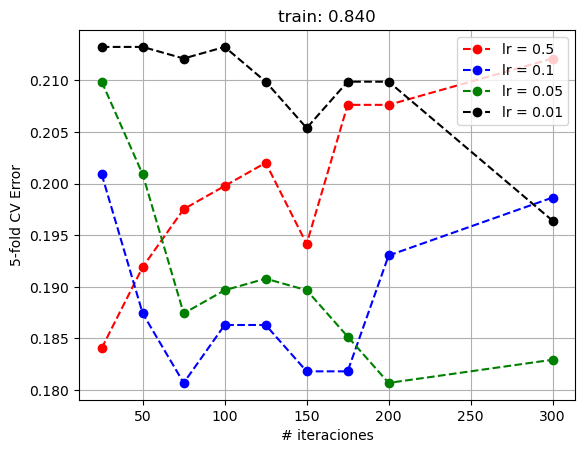

In [26]:
# calculamos métricas globales
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingClassifier(random_state=0, max_depth=2,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f'%(bt.score(X_train,y_train)))
plt.grid()
plt.show()

In [30]:
!pip install xgboost

In [32]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0, max_depth=3,learning_rate=0.01, n_estimators=500)
xgb.fit(X_train,y_train)

print("Train: ",xgb.score(X_train,y_train))

Train:  0.8428731762065096


In [33]:
# Test predictions
predictions = xgb.predict(X_test)

### Conclusions
* Women had a higher survival rate than men.
* 1st Class passengers had better survival rate than 3rd Class.
* As passengers’ age increases, it is more likely that they will not survive.

### Submission

In [34]:
output=pd.DataFrame({'passengerId':submission.PassengerId, 'survived':predictions})
output.to_csv('submission.csv', index=False)
print("File created.")

File created.
